<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 3
</center>
Авторы материала: аспирант Мехмата МГУ Евгений Колмаков, программист-исследователь Mail.ru Group Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 3. Опциональная часть 
## <center> Реализация алгоритма построения дерева решений

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.base import BaseEstimator
from sklearn.datasets import make_classification, make_regression, load_digits, load_boston
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error

**Необходимо реализовать класс `DecisionTree`**

**Спецификация:**
- класс наследуется от `sklearn.BaseEstimator`;
- конструктор содержит следующие параметры: 
    `max_depth` - максимальная глубина дерева (по умолчанию - `numpy.inf`); 
    `min_samples_split` - минимальное число объектов в вершине, при котором происходит её разбиение (по умолчанию - 2); 
    `criterion` - критерий разбиения (для классификации - 'gini' или 'entropy', для регрессии - 'variance' или 'mad_median'; 
    по умолчанию - 'gini');
    
    Функционал, значение которого максимизируется для поиска оптимального разбиения в данной вершине имеет вид
    $$Q(X, j, t) = F(X) - \dfrac{|X_l|}{|X|} F(X_l) - \dfrac{|X_r|}{|X|} F(X_r),$$
    где $X$ - выборка, находящаяся в текущей вершине, $X_l$ и $X_r$ - разбиение выборки $X$ на две части 
    по предикату $[x_j < t]$, а $F(X)$ -критерий разбиения.
    
    Для классификации: пусть $p_i$ - доля объектов $i$-го класса в выборке $X$.
    
    'gini': Неопределенность Джини $F(X) = 1 -\sum_{i = 1}^K p_i^2$.
    
    'entropy': Энтропия $F(X) = -\sum_{i = 1}^K p_i \log_2(p_i)$.
    
    Для регрессии: $y_j = y(x_j)$ - ответ на объекте $x_j$, $y = (y_1, \dots, y_{|X|})$ - вектор ответов.
    
    'variance': Дисперсия (среднее квадратичное отклонение от среднего) $F(X) = \dfrac{1}{|X|} \sum_{x_j \in X}(y_j - \dfrac{1}{|X|}\sum_{x_i \in X}y_i)^2$
    
    'mad_median': Среднее отклонение от медианы $F(X) = \dfrac{1}{|X|} \sum_{x_j \in X}|y_j - \mathrm{med}(y)|$
    
- класс имеет методы `fit`, `predict` и `predict_proba`;
- метод `fit` принимает матрицу объектов `X` и вектор ответов `y` (объекты `numpy.ndarray`) и возвращает экземпляр класса
    `DecisionTree`, представляющий собой решающее дерево, обученное по выборке `(X, y)` с учётом заданных в конструкторе параметров; 
- метод `predict_proba` принимает матрицу объектов `X` и возвращает матрицу `P` размера `X.shape[0] x K`, где `K` - число классов, такую что $p_{ij}$ есть вероятность принадлежности объекта, заданного $i$-ой строкой матрицы X к классу $j \in \{1, \dots, K\}$.
- метод `predict` принимает матрицу объектов и возвращает вектор предсказанных ответов; в случае классификации - это 
    наиболее многочисленный класс в листе, в который попал объект, а в случае регрессии - среднее значение ответов по 
    всем объектам этого листа;

In [2]:
from collections import Counter

#def entropy(y):
#    return -sum(x/len(y) * np.log2(x/len(y)) for x in Counter(y).values())

#def gini(y):
#    return 1 - sum((x / len(y)) ** 2 for x in Counter(y).values())

def entropy(y):    
    p = [len(y[y == k]) / len(y) for k in np.unique(y)]
    return -np.dot(p, np.log2(p))

def gini(y):
    p = [len(y[y == k]) / len(y) for k in np.unique(y)]
    return 1 - np.dot(p, p)

def variance(y):
    return np.var(y)
    #return sum([(x - sum(y) / len(y))**2 for x in y])/len(y)

def mad_median(y):
    return sum([abs(x - np.median(y)) for x in y])/len(y)

In [3]:
class TreeNode:
    def __init__(self, col=-1, value=None, results=None, left=None, right=None, is_leaf=False):
        self.col = col
        self.value = value
        self.results = results
        self.left = left
        self.right = right
        self.is_leaf = is_leaf

def divide(X, y, col, value):
    return (
        X[X[:,col] < value],
        X[X[:,col] >= value],
        y[X[:,col] < value],
        y[X[:,col] >= value]
    )


In [4]:
class DecisionTree(BaseEstimator):
    
    def __init__(self, max_depth=np.inf, min_samples_split=2, 
                 criterion='gini', debug=False):
        BaseEstimator.__init__(self)
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.criterion = criterion
        self.debug = debug
    
    def build_tree(self, X, y, depth = 0):
        if depth >= self.max_depth or len(set(y)) == 1:
            return TreeNode(results=y, is_leaf=True)
        else:
            F = self.F
            best_g = 0
            best_col = None
            best_value = None
            best_sets = None
            Fy = F(y)
            for col in range(X.shape[1]):
                for value in list(set(X[:,col])):
                    Xl,Xr,yl,yr = divide(X, y, col, value)
                    if yl.shape[0] < self.min_samples_split or yr.shape[0] < self.min_samples_split:
                        continue
                    p = yl.shape[0]/y.shape[0]
                    g = Fy - p * F(yl) - (1 - p) * F(yr)
                    if g > best_g:
                        best_g = g
                        best_col, best_value = col, value
                        best_sets = (Xl, Xr, yl, yr)
            if best_g > 0:
                leftbranch = self.build_tree(best_sets[0], best_sets[2], depth + 1)
                rightbranch = self.build_tree(best_sets[1], best_sets[3], depth + 1)
                return TreeNode(col = best_col, value = best_value, left=leftbranch, right=rightbranch)
            else:
                return TreeNode(results=y, is_leaf=True)

    def fit(self, X, y):
        self.F = {'gini':gini,
                         'entropy':entropy,
                         'variance':variance,
                         'mad_median':mad_median
                        }.get(self.criterion, 'gini')
        self.tree = self.build_tree(X, y)
        self.nclasses = np.unique(y)
        return self
        
    def find_predict(self, X, tree):
        if tree.is_leaf:
            return tree.results
        else:
            branch = None
            if X[tree.col] < tree.value:
                branch = tree.left
            else:
                branch = tree.right
        return self.find_predict(X,branch)
            
    def predict(self, X):
        res = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            y = self.find_predict(X[i], self.tree)
            if self.criterion in ['gini','entropy']:
                res[i] = np.argmax(np.bincount(y))
            else:
                res[i] = np.mean(y)
        return res
        
    def predict_proba(self, X, indent=''):
        res = np.zeros([X.shape[0], len(self.nclasses)])
        for i in range(X.shape[0]):
            y = self.find_predict(X[i], self.tree)
            res[i] = np.bincount(y, minlength=len(self.nclasses)) / y.shape[0]
        return res
    
    def print_tree(self, tree=None, indent=''):
        if tree == None:
            tree = self.tree
        if tree.is_leaf:
            print(tree.results)
        else:
            print("Column {} : {}?".format(tree.col, tree.value))
            
            print(indent,'True->'),
            self.print_tree(tree.left,indent+'  ')
            print(indent,'False->'),
            self.print_tree(tree.right,indent+'  ')

## Тестирование реализованного алгоритма

### Классификация

С помощью метода `load_digits` загрузите датасет `digits`. Разделите выборку на обучающую и тестовую с помощью метода `train_test_split`, используйте значения параметров `test_size=0.2`, `random_state=17`. Попробуйте обучить неглубокие решающие деревья и убедитесь, что критерии gini и entropy дают разные результаты.

In [5]:
X, y = load_digits(return_X_y=True)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=11)

In [6]:
tree = DecisionTree(max_depth=2, criterion="gini", debug=False)
tree.fit(X_train, y_train)
tree.print_tree()

Column 36 : 1.0?
 True->
Column 42 : 6.0?
   True->
[9 9 9 9 9 5 9 9 9 5 5 9 9 9 5 9 5 5 9 9 5 5 9 9 3 9 5 5 9 5 9 9 9 5 9 9 9
 9 5 9 9 5 9 9 9 9 9 9 9 9 9 5 9 5 9 9 9 9 9 9 2 9]
   False->
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 9 0 4 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 5 0 6 0 0 0 0 0 4 0 0 0 0
 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 6 0 0 2 0 5 5 0 0 0 0 0 0 0 0 0 0 0 4 0
 0 0 8 6 0 6 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 6 0 5 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0]
 False->
Column 21 : 1.0?
   True->
[4 5 6 6 5 1 6 5 6 6 2 5 5 5 2 6 6 6 6 6 4 5 5 5 6 5 1 1 2 1 5 6 6 6 2 3 5
 6 5 6 6 6 6 5 6 5 6 5 4 5 6 5 6 5 6 5 6 3 1 6 5 2 2 5 6 1 4 1 6 5 5 6 5 5
 2 1 5 2 5 6 7 5 1 5 4 1 6 5 5 5 5 1 5 6 6 4 4 5 5 1 5 6 6 5 5 5 6 6 5 1 5
 1 5 5 6 4 5 6 3 1 8 6 6 6 7 4 3 1 2 3 5 5 5 5 2 5 6 4 6 6 5 5 6 6 6 3 1 5
 5 5 5 3 6 2 5 6 6 6 6 5 5 2 1 1 6 5 5 6 4 2 6 2 5 4 6 4 6 8 1 6 5 2 6 6 6
 6 6 6 5 5 5 1 5 2 6 1 1 1 5 6 5 9 5 5 6 5 6 2 5 6 6 4 4 5 6 5 6 5 6 6 2 6
 1

In [7]:
accuracy_score(y_valid, tree.predict(X_valid))

0.3

In [8]:
tree.nclasses

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [9]:
tree_entropy = DecisionTree(max_depth=2, criterion="entropy", debug=False)
tree_entropy.fit(X_train, y_train)
accuracy_score(y_valid, tree_entropy.predict(X_valid))

0.3416666666666667

С помощью 5-кратной кросс-валидации (`GridSearchCV`) подберите оптимальное значение параметров `max_depth` и `criterion`. Для параметра `max_depth` используйте диапазон значений - range(3, 11), а для criterion - {'gini', 'entropy'}. Критерий качества `scoring`='accuracy'.

In [10]:
tree_params = {'max_depth': list(range(3,11)), 'criterion':['gini', 'entropy']}
tree_grid = GridSearchCV(tree, tree_params, cv=5, n_jobs=-1, verbose=True, scoring='accuracy')
tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.3min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTree(criterion='gini', debug=False, max_depth=2, min_samples_split=2),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=True)

In [11]:
from sklearn.tree import DecisionTreeClassifier

sk_tree = DecisionTreeClassifier(criterion='entropy', max_depth=8, random_state=17)
sk_tree.fit(X_train,y_train)
sk_tree_params = {'max_depth': list(range(3,11)), 'criterion':['gini', 'entropy']}
sk_tree_grid = GridSearchCV(sk_tree, sk_tree_params, cv=5, n_jobs=-1, verbose=True, scoring='accuracy')
sk_tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    0.6s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=True)

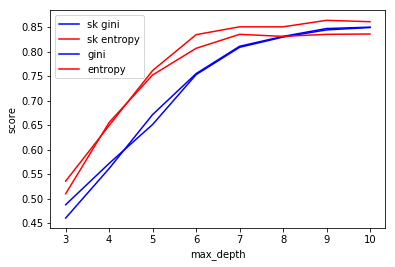

In [12]:
sk_scores = sk_tree_grid.cv_results_['mean_test_score']
plt.plot(sk_tree_params['max_depth'], sk_scores[:len(sk_scores)//2], label='sk gini', color='b');
plt.plot(sk_tree_params['max_depth'], sk_scores[len(sk_scores)//2:], label='sk entropy', color='r');
scores = tree_grid.cv_results_['mean_test_score']
plt.plot(tree_params['max_depth'], scores[:len(scores)//2], label='gini', color='b');
plt.plot(tree_params['max_depth'], scores[len(scores)//2:], label='entropy', color='r');

plt.xlabel("max_depth")
plt.ylabel("score");
plt.legend();

In [13]:
sk_tree_grid.best_params_

{'criterion': 'entropy', 'max_depth': 9}

Постройте графики средних значений критерия качества `accuracy` для критериев `gini` и `entropy` в зависимости от `max_depth`.

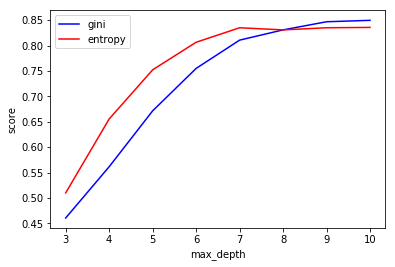

In [14]:
scores = tree_grid.cv_results_['mean_test_score']
plt.plot(tree_params['max_depth'], scores[:len(scores)//2], label='gini', color='b');
plt.plot(tree_params['max_depth'], scores[len(scores)//2:], label='entropy', color='r');
plt.xlabel("max_depth")
plt.ylabel("score");
plt.legend();

**Выберите верные утверждения:**
1. Оптимальное значение max_depth для каждого критерия достигается внутри отрезка [3, 10] (то есть на отрезке [4, 9]).
2. На отрезке [3, 10] построенные графики не пересекаются.
3. На отрезке [3, 10] построенные графики пересекаются ровно один раз.
4. Наилучшее качество при max_depth на интервале [3, 10] достигается на критерии gini.
5. Хотя бы для одного из критериев значение accuracy строго возрастает с ростом значения max_depth на интервале [3, 10].

In [15]:
tree_grid.best_params_

{'criterion': 'gini', 'max_depth': 10}

**Чему равны найденные оптимальные значения параметров max_depth и criterion?**
1. max_depth = 4, criterion = 'gini';
2. max_depth = 7, criterion = 'entropy';
3. max_depth = 10, criterion = 'entropy';
4. max_depth = 10, criterion = 'gini';
5. max_depth = 3, criterion = 'entropy';
6. max_depth = 9, criterion = 'gini';

Используя найденные оптимальные значения max_depth и criterion, обучите решающее дерево на X_train, y_train и вычислите вероятности принадлежности к классам для X_test.

In [23]:
tree_best = DecisionTree(max_depth=10, criterion='gini')
tree_best.fit(X_train, y_train)
print(accuracy_score(y_valid, tree_best.predict(X_valid)))
arr = tree_best.predict_proba(X_valid)
np.mean(arr, axis=0)

0.8277777777777777


array([0.09444444, 0.11079902, 0.09861111, 0.10811538, 0.11388889,
       0.08855219, 0.08472222, 0.08231481, 0.10364598, 0.11490594])

Для полученной матрицы вычислите усредненные по всем объектам из `X_test` значения вероятностей принадлежности к классам.

**Вопрос:** Чему равна максимальная вероятность в полученном векторе?
1. 0.11218791
2. 0.11783761
3. 1.0
4. 0.0875

### Регрессия

С помощью метода `load_boston` загрузите датасет `boston`. Разделите выборку на обучающую и тестовую с помощью метода `train_test_split`, используйте значения параметров `test_size=0.2`, `random_state=17`. Попробуйте обучить неглубокие регрессионные деревья и убедитесь, что критерии `variance` и `mad_median` дают разные результаты.

In [17]:
Xb, yb = load_boston(return_X_y=True)
Xb_train, Xb_valid, yb_train, yb_valid = train_test_split(Xb, yb, test_size=0.2, random_state=11)

In [18]:
tree_b = DecisionTree(max_depth=4, criterion="variance", debug=False)
tree_b.fit(Xb_train, yb_train)
tree_b.predict(Xb_valid)
tree_b.print_tree()

Column 5 : 6.98?
 True->
Column 12 : 14.43?
   True->
Column 7 : 1.5106?
     True->
Column 0 : 8.26725?
       True->
[50. 50.]
       False->
[50.  27.9]
     False->
Column 5 : 6.546?
       True->
[21.  19.6 18.2 24.4 24.7 20.2 20.1 20.6 24.1 14.5 23.8 19.9 24.6 23.
 25.  23.7 20.3 26.4 20.4 23.1 20.6 20.9 18.9 23.6 21.5 24.8 18.6 24.3
 18.4 22.6 24.1 24.8 17.1 25.  19.2 19.5 25.2 23.  22.1 19.3 20.8 19.
 24.3 21.7 17.5 19.7 23.3 22.7 22.2 20.9 24.4 22.6 19.6 22.7 18.6 23.7
 18.3 21.2 22.5 16.1 20.  24.  21.6 20.5 20.  20.4 23.3 21.4 22.8 21.2
 19.3 16.2 22.9 19.4 24.6 24.4 17.2 19.5 19.8 28.7 19.6 26.4 21.2 22.
 20.1 24.3 19.4 28.1 18.2 25.3 20.  23.4 21.2 15.3 19.9 20.4 21.9 18.9
 20.6 21.8 21.9 25.  23.9 23.8 23.5 20.1 25.  22.9 23.1 20.8 23.1 29.6
 23.  17.6 23.2 19.3 20.6 24.7 23.9 18.2 22.8 21.4 19.9 16.1 21.7 20.2
 24.7 20.8 22.6 11.9 20.7 27.  18.5 19.3 17.4 25.  19.6 21.6 22.2 36.2
 24.5 23.8 21.1 16.8 23.2 21.4 20.3 22.2 19.1 23.  22.  20.6 21.  19.8
 23.2 22.9 20.6 21.7 

In [19]:
from sklearn.tree import DecisionTreeRegressor

tree_sk = DecisionTreeRegressor(criterion='mse', max_depth=4, random_state=17)
tree_sk.fit(Xb_train, yb_train)
tree_sk.predict(Xb_valid)


array([21.59691358, 16.17380952, 28.04583333, 50.        ,  9.57741935,
       14.61176471, 21.59691358,  9.57741935, 47.57777778, 21.59691358,
       19.55517241, 16.17380952, 21.59691358, 21.59691358,  9.57741935,
       16.17380952, 33.42962963, 33.42962963, 21.59691358, 14.61176471,
       21.59691358, 33.42962963, 47.57777778, 28.04583333, 16.17380952,
       14.61176471, 16.17380952, 16.17380952, 28.04583333, 21.59691358,
        9.57741935,  9.57741935, 14.61176471,  9.57741935, 21.59691358,
       21.59691358, 21.59691358, 21.59691358, 14.61176471, 28.04583333,
       28.04583333, 28.04583333, 28.04583333, 14.61176471, 21.59691358,
       21.59691358, 21.59691358, 28.04583333,  9.57741935, 21.59691358,
       21.59691358, 36.95      , 21.59691358, 28.04583333, 47.57777778,
       33.42962963, 33.42962963, 19.55517241, 21.59691358, 14.61176471,
       19.55517241, 28.04583333, 14.61176471, 21.59691358, 21.59691358,
        9.57741935, 14.61176471, 14.61176471, 28.04583333, 41.45

In [ ]:
tree_b_mad = DecisionTree(max_depth=4, criterion="mad_median", debug=False)
tree_b_mad.fit(Xb_train, yb_train)
tree_b_mad.predict(Xb_valid)

С помощью 5-кратной кросс-валидации подберите оптимальное значение параметров `max_depth` и `criterion`. Для параметра `max_depth` используйте диапазон значений - `range(2, 9)`, а для `criterion` - {'variance', 'mad_median'}. Критерий качества `scoring`='neg_mean_squared_error'.

In [ ]:
tree_b_params = {'max_depth': list(range(3,9)), 'criterion':['variance', 'mad_median']}
tree_b_grid = GridSearchCV(tree_b, tree_b_params, cv=5, n_jobs=-1, verbose=True, scoring='neg_mean_squared_error')
tree_b_grid.fit(Xb_train, yb_train)

In [ ]:
DecisionTreeRegressor?

In [ ]:
from sklearn.tree import DecisionTreeRegressor

rsk_tree = DecisionTreeRegressor(criterion='mse', max_depth=4, random_state=17)
rsk_tree.fit(Xb_train,yb_train)
rsk_tree_params = {'max_depth': list(range(3,9))}
rsk_tree_grid = GridSearchCV(rsk_tree, rsk_tree_params, cv=5, n_jobs=-1, verbose=True, scoring='neg_mean_squared_error')
rsk_tree_grid.fit(Xb_train, yb_train)

Постройте графики средних значений критерия качества `neg_mean_squared_error` для критериев `variance` и `mad_median` в зависимости от `max_depth`.

In [ ]:
scoresb = tree_b_grid.cv_results_['mean_test_score']
rscoresb = rsk_tree_grid.cv_results_['mean_test_score']

plt.plot(rsk_tree_params['max_depth'], rscoresb, label='mse', color='g');

plt.plot(tree_b_params['max_depth'], scoresb[:len(scoresb)//2], label='variance', color='b');
plt.plot(tree_b_params['max_depth'], scoresb[len(scoresb)//2:], label='mad_median', color='r');

plt.xlabel("max_depth")
plt.ylabel("score");
plt.legend();

**Выберите верные утверждения:**
1. На отрезке [2, 8] построенные графики не пересекаются.
2. На отрезке [2, 8] построенные графики пересекаются ровно один раз.
3. Оптимальное значение max_depth для каждого из критериев достигается на границе отрезка [2, 8].
4. Наилучшее качество при max_depth in range(2, 9) достигается на критерии variance.
5. График качества ровно для одного из критериев имеет явно выраженный пик.

In [ ]:
tree_b_grid.best_params_

**Чему равны найденные оптимальные значения параметров `max_depth` и `criterion`?**
1. max_depth = 9, criterion = 'variance';
2. max_depth = 5, criterion = 'mad_median';
3. max_depth = 4, criterion = 'variance';
4. max_depth = 2, criterion = 'mad_median';
5. max_depth = 4, criterion = 'mad_median';
6. max_depth = 8, criterion = 'variance';